Dataset from https://www.physionet.org/content/eegmmidb/1.0.0/

In [1]:
import pandas as pd

In [2]:
import mne

In [3]:
import numpy as np

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
from pylab import rcParams

In [6]:
from tqdm import tqdm_notebook

In [7]:
from scipy.signal import periodogram

In [8]:
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.viz.utils import center_cmap

In [9]:
subject = 1
task = 4

In [10]:
events_path = "./filtered/S{0:03d}R{1:02d}.edf".format(subject, task)
baseline_path = "./filtered/S{0:03d}R{1:02d}.edf".format(subject, 1)

In [11]:
# events_path = "./full-data/eegmmidb-1.0.0.physionet.org/S{0:03d}/S{0:03d}R{1:02d}.edf".format(subject, task)
# baseline_path = "./full-data/eegmmidb-1.0.0.physionet.org/S{0:03d}/S{0:03d}R{1:02d}.edf".format(subject, 1)

In [12]:
events_eeg = mne.io.read_raw_fif(
    events_path,
    preload=True
)

Opening raw data file ./filtered/S001R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<ipython-input-12-a0d46778d20a>:3: RuntimeWarning: This filename (./filtered/S001R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True


In [13]:
baseline_eeg = mne.io.read_raw_fif(
    baseline_path,
    preload=True,
)

Opening raw data file ./filtered/S001R01.edf...
Isotrak not found
    Range : 0 ... 9759 =      0.000 ...    60.994 secs
Ready.
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


<ipython-input-13-2da3423c04ef>:3: RuntimeWarning: This filename (./filtered/S001R01.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True,


In [14]:
# eeg = mne.concatenate_raws([baseline_eeg, events_eeg])

In [15]:
baseline_eeg.set_annotations(events_eeg.annotations)

<ipython-input-15-9c2912aa9c9d>:1: RuntimeWarning: Omitted 15 annotation(s) that were outside data range.
  baseline_eeg.set_annotations(events_eeg.annotations)
<ipython-input-15-9c2912aa9c9d>:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  baseline_eeg.set_annotations(events_eeg.annotations)


<Raw  |  S001R01.edf, n_channels x n_times : 62 x 9760 (61.0 sec), ~4.7 MB, data loaded>

In [16]:
baseline_eeg.rename_channels(lambda x: x.strip('.'))
events_eeg.rename_channels(lambda x: x.strip('.'))

In [17]:
eeg = events_eeg

where ERDs occur in the contralateral
channel and ERSs in the ipsilateral channel. 

In order to obtain a reference value, the alpha wave
energy for each channel is estimated 1 s before the hint is
displayed on the monitor, while the subject is still concentrating
himself to focus on the screen and being instructed to
not have thoughts about hand motion

Since the ERD must last for 2 s on average, for an alpha
wave type

Видны артефакты:
- Моргания
- Шум

От них нужно избавиться

# Simple and stupid

In [21]:
main_events, main_annot_to_events = mne.events_from_annotations(events_eeg)

Used Annotations descriptions: ['T1', 'T0', 'T2']


In [22]:
picks = mne.pick_channels(events_eeg.info["ch_names"], ["C3", "Cz", "C4"])

In [85]:
data, times = events_eeg[:]
c3_data = data[picks[0], :]

In [86]:
window_size = (times < 1).sum()
step_size = window_size // 16

In [87]:
def get_fourier_transform(data):
    global window_size, step_size
    frequencies = []
    for window in tqdm_notebook(range(0, data.shape[0] - window_size, step_size)):
        chunk = data[window:window + window_size]
        frequency_values = np.abs(np.fft.fft(chunk, axis=0))[:window_size // 2]
#         _, frequency_values = periodogram(chunk, window_size, axis=0)
        frequencies.append(frequency_values)
    return np.vstack(frequencies)

In [88]:
def get_relative_power(frequencies, main_events):
    baseline = None
    relative_values = []

    for index, (start, _, event) in enumerate(main_events):
        if (index + 1) == main_events.shape[0]:
            end = frequencies.shape[0] * step_size
        else:
            end, _, _ = main_events[index + 1]
            
        if event == 1:
            baseline = frequencies[(start // step_size):(end // step_size)].mean(axis=0)
        
        for power_index in range(start // step_size, end // step_size):
            relative_values += [(frequencies[power_index, :] - baseline) / (baseline)]
        
    return np.vstack(relative_values)    

In [89]:
frequencies = get_fourier_transform(c3_data)

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [90]:
relative_values = get_relative_power(frequencies, main_events)

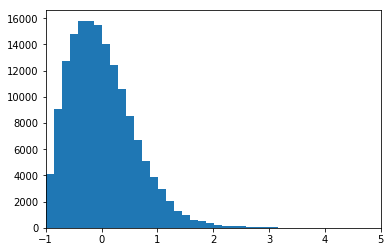

In [91]:
plt.hist(relative_values.reshape(-1), bins=40)
plt.xlim(-1, 5)
plt.show()

In [92]:
vmin = -1 #np.quantile(relative_values, 0.001)
vmax = 2 #np.quantile(relative_values, 0.999)

In [93]:
# plt.figure(figsize=(200, 50))
# plt.imshow(relative_values[:, 5:30], vmin=vmin, vmax=vmax)
# for start, _, event in main_events:
#     plt.axhline((start // step_size), color=["red", "yellow", "white"][event - 1])
# plt.axvline(7, color="white")
# plt.axvline(14, color="white")

In [94]:
all_events = {}

for index, (start, _, event) in enumerate(main_events):
    start = start // step_size
    if (index + 1) == main_events.shape[0]:
        end = frequencies.shape[0]
    else:
        end, _, _ = main_events[index + 1] // step_size
    window = relative_values[start - 16:end]
    if event not in all_events:
        all_events[event] = [window]
    else:
        all_events[event] += [window]
        
#     print(start, end)
#     plt.axhline((start // step_size), color=["red", "yellow", "white"][event - 1])

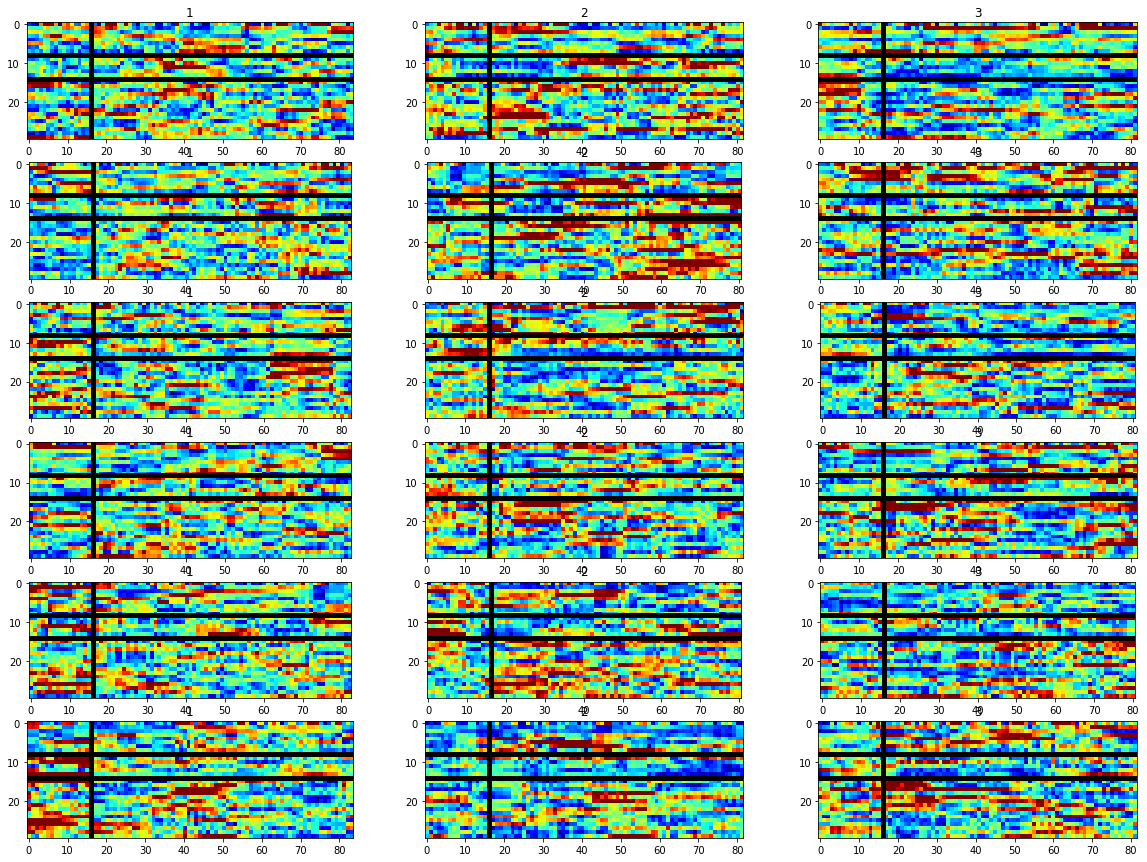

In [95]:
plt.figure(figsize=(20, 15))
for event, windows in all_events.items():
    for index, window in enumerate(windows[1:7]):
        plt.subplot(6, 3, 3 * index  + event)
        plt.title(event)
        plt.imshow(window.T[0:30], vmin=-1, vmax=1, cmap="jet")
        plt.axhline(8, color="black", linewidth=5)
        plt.axhline(14, color="black", linewidth=5)
        plt.axvline(16, color="black", linewidth=5)
plt.show()

In [64]:
min_shape = min(
    min([w.shape[0] for w in all_events[1] if w.shape[0] > 0]), 
    min([w.shape[0] for w in all_events[2]]), 
    min([w.shape[0] for w in all_events[3]])
)

In [65]:
def prepare_signal(window, min_shape):
    return np.vstack([
        window[:, 8:13].mean(axis=1)[:min_shape],
        np.ones(min_shape)
    ]).min(axis=0)

In [97]:
all_signals = {}

for event, windows in all_events.items():
    all_signals[event] = []
    for window in windows:
        if not len(window):
            continue
        all_signals[event] += [prepare_signal(window, min_shape)]

Пайплайн:
- Получаем чанк
- Конвертируем в частоты
- Если бэйслайна нет - кладем в бэйслайн 
- Релейтим
- Если похож на бэйслайн - обновляем бэйслайн
- Если не похож на бэйслайн - определяем движение

# Events extraction

In [755]:
main_events, main_annot_to_events = mne.events_from_annotations(events_eeg)

Used Annotations descriptions: ['T0', 'T1', 'T2']


In [756]:
baseline_events, baseline_annot_to_events = mne.events_from_annotations(baseline_eeg)
for i in baseline_events:
    i[-1] = 4

Used Annotations descriptions: ['T0', 'T1', 'T2']


In [761]:
tmin = -2
tmax = 3

In [762]:
picks = mne.pick_channels(events_eeg.info["ch_names"], ["C3", "Cz", "C4"])

In [763]:
picks

array([ 8, 10, 12])

In [764]:
main_epochs = mne.Epochs(
    events_eeg, 
    main_events, 
    event_id={
        "none": 1,
        "left": 2,
        "right": 3
    },
    tmin=tmin - 0.5,
    tmax=tmax + 0.5,
    preload=True
)
print(main_epochs)

30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
1 bad epochs dropped
<Epochs  |   29 events (all good), -2.5 - 3.5 sec, baseline [None, 0], ~13.3 MB, data loaded,
 'left': 8
 'none': 14
 'right': 7>


In [765]:
baseline_epochs = mne.Epochs(
    baseline_eeg, 
    baseline_events, 
    event_id={
        "baseline": 4
    },
    tmin=tmin - 0.5,
    tmax=tmax + 0.5,
    preload=True
)[1:-1]
print(baseline_epochs)

15 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 15 events and 961 original time points ...
1 bad epochs dropped
<Epochs  |   12 events (all good), -2.5 - 3.5 sec, baseline [None, 0], ~5.6 MB, data loaded,
 'baseline': 12>


In [766]:
# epochs = mne.concatenate_epochs([main_epochs, baseline_epochs])

# Epochs definition

- T0 corresponds to rest
- T1 corresponds to onset of motion (real or imagined) of
    - the left fist (in runs 3, 4, 7, 8, 11, and 12)
    - both fists (in runs 5, 6, 9, 10, 13, and 14)
- T2 corresponds to onset of motion (real or imagined) of
    - the right fist (in runs 3, 4, 7, 8, 11, and 12)
    - both feet (in runs 5, 6, 9, 10, 13, and 14)

# Attemps

8 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<ipython-input-333-7acae9488666>:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.epochs.plot_epochs_image(epochs[event].crop(-0.1, 1), sigma=1, picks=[1])


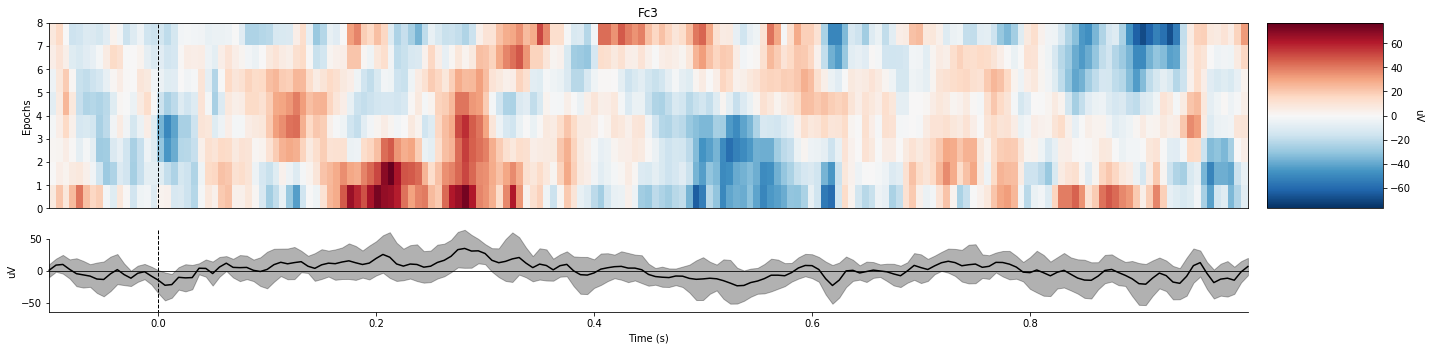

7 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<ipython-input-333-7acae9488666>:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.epochs.plot_epochs_image(epochs[event].crop(-0.1, 1), sigma=1, picks=[1])


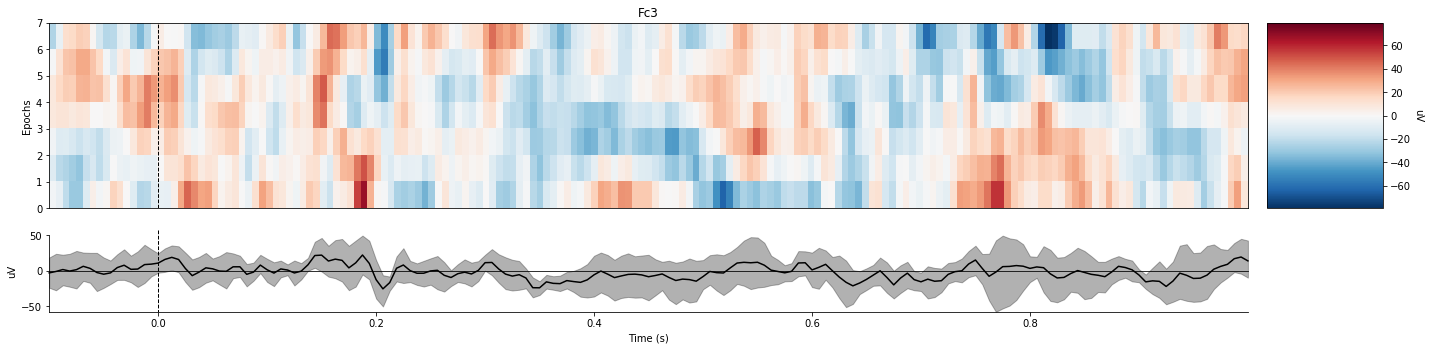

11 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<ipython-input-333-7acae9488666>:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.epochs.plot_epochs_image(epochs[event].crop(-0.1, 1), sigma=1, picks=[1])


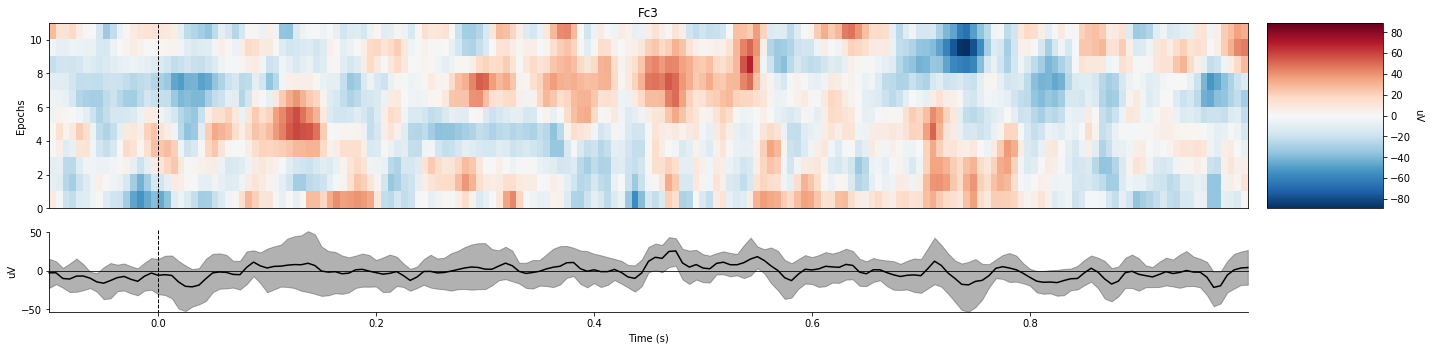

In [333]:
rcParams['figure.figsize'] = 20, 5
for event in ["left", "right", "baseline"]:
    mne.viz.epochs.plot_epochs_image(epochs[event].crop(-0.1, 1), sigma=1, picks=[1])

# Time-frequency analysis

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4077682/

Просчитать статистическую значимость ERD-ERS для каждого пациента и каждого случая

In [320]:
freqs = np.arange(5, 30, 1)  # frequencies of interest
n_cycles = freqs  # number of cycles in Morlet wavelet

In [321]:
def draw_power(event, baseline):
    tmin = -3
    tmax = 3
    rcParams['figure.figsize'] = 21, 3
    erds = {}
    for i, channel in enumerate(["C3", "Cz", "C4"]):
        plt.subplot(130 + i + 1)
        power, itc = mne.time_frequency.tfr_multitaper(
            epochs[event][1:8], 
            freqs=freqs, 
            n_cycles=n_cycles,
            return_itc=True, 
            decim=3, 
            n_jobs=1,
            picks=[channel]
        )
        power.apply_baseline(baseline, mode='percent')
        power.crop(tmin, tmax)
        power.plot(
            show=False, 
            axes=plt.gca(),
            vmin=-1.5,
            vmax=1.5
        )
        plt.title(channel)
        plt.axvline(0)
        plt.axhline(8)
        plt.axhline(13)
        erds[channel] = power
    return erds

Как по известному спектру можно классифицировать попытку?
- 

Applying baseline correction (mode: percent)
No baseline correction applied
Applying baseline correction (mode: percent)
No baseline correction applied
Applying baseline correction (mode: percent)
No baseline correction applied


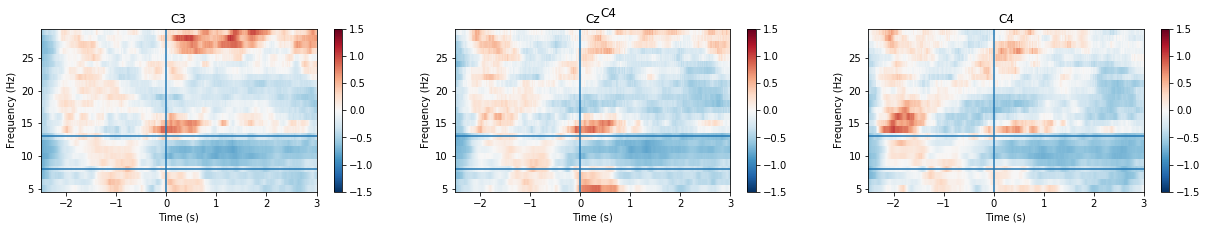

In [331]:
p = draw_power("right", [tmin, -0.1])

Applying baseline correction (mode: percent)
No baseline correction applied
Applying baseline correction (mode: percent)
No baseline correction applied
Applying baseline correction (mode: percent)
No baseline correction applied


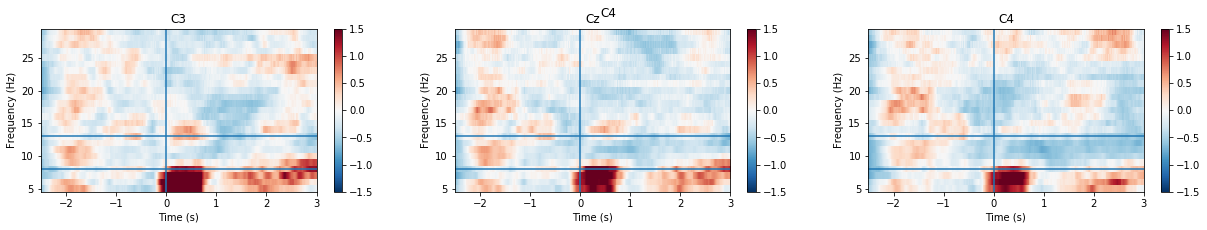

In [330]:
p = draw_power("left",  [tmin, -0.1])

Applying baseline correction (mode: percent)
No baseline correction applied
Applying baseline correction (mode: percent)
No baseline correction applied
Applying baseline correction (mode: percent)
No baseline correction applied


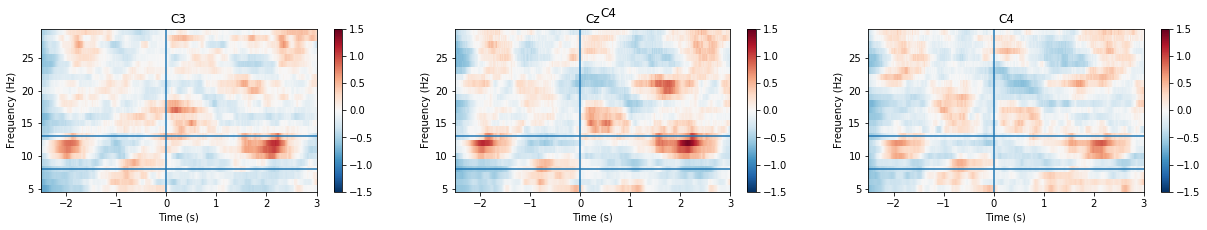

In [329]:
p = draw_power("baseline",  [tmin, -0.1])

- Beta ERS
- Gamma ERS
- Low alpha ERD

Spectral effects:
- Lower alpha ERD (6-10 Hz) - all tasks
- Higher alpha ERD (10-14 Hz) - visual stim
- Beta ERS (16-21, 19-26) right after the movement, about 600ms
- Gamma ERS (35-45 Hz) after the stim and before the movement, 
- Delta ERS right after the stim (finger), some seconds

Для распознавания используем спектр, нормированный по бэйслайну за последние секунды без действия

Сделать реал-тайм распознавание на основе появления существенной разности в активностях в ожидаемых частях спектра

# Draw ERDS

In [33]:
vmin, vmax = -1, 1  # set min and max ERDS values in plot
baseline = [-1, 0]  # baseline interval (in s)
cmap = center_cmap(plt.cm.RdBu, vmin, vmax)  # zero maps to white
kwargs = dict(n_permutations=100, step_down_p=0.05,
              buffer_size=None)  # for cluster test

In [34]:
tfr = mne.time_frequency.tfr_multitaper(
    epochs, 
    freqs=freqs, 
    n_cycles=n_cycles,
    use_fft=True, 
    return_itc=False, 
    average=False,
    decim=2
)

Not setting metadata


In [35]:
tfr.crop(tmin, tmax)

<EpochsTFR  |  time : [-1.000000, 3.000000], freq : [7.000000, 44.000000], epochs : 29, channels : 62, ~167.4 MB>

In [839]:
# Without action
tfr.apply_baseline(baseline, mode="percent")

Applying baseline correction (mode: percent)


<EpochsTFR  |  time : [-1.000000, 3.000000], freq : [7.000000, 44.000000], epochs : 29, channels : 3, ~8.1 MB>

Using a threshold of 1.894579
stat_fun(H1): min=-9.959330 max=4.565568
Running initial clustering
Found 44 clusters
Permuting 99 times...
[........................................] 100.00%  |
Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.894579
stat_fun(H1): min=-9.959330 max=4.565568
Running initial clustering
Found 59 clusters
Permuting 99 times...
[........................................] 100.00%  |
Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.894579
stat_fun(H1): min=-12.736205 max=4.363360
Running initial clustering
Found 27 clusters
Permuting 99 times...
[........................................] 100.00%  |
Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...
[...............

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


[........................................] 100.00%  |
Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.943180
stat_fun(H1): min=-16.036908 max=5.934944
Running initial clustering
Found 62 clusters
Permuting 99 times...
[........................................] 100.00%  |
Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...
[........................................] 100.00%  |
Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.943180
stat_fun(H1): min=-8.995151 max=5.287308
Running initial clustering
Found 28 clusters
Permuting 99 times...
[........................................] 100.00%  |
Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude fr

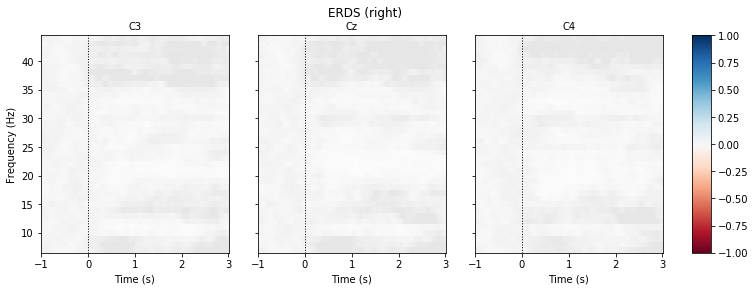

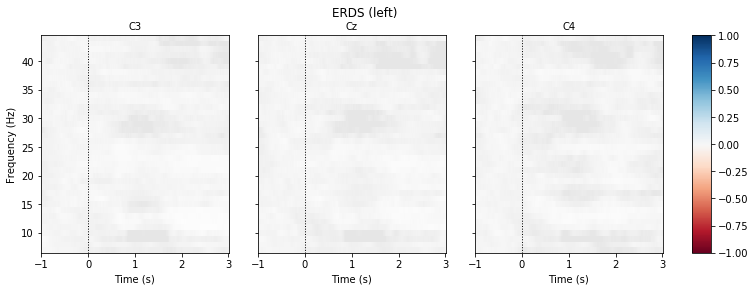

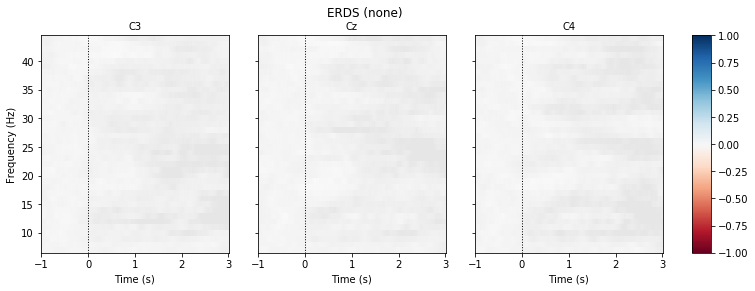

In [840]:
for event in ["right", "left", "none"]:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=-1,
                                     **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = 0*c[..., p <= 1].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], vmin=vmin, vmax=vmax, cmap=(cmap, False),
                              axes=ax, colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if not ax.is_first_col():
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1])
    fig.suptitle("ERDS ({})".format(event))
    fig.show()

Визуализировать для как можно большего количества электродов

# Prepare EOG and ECG removal

http://mne.tools/mne-biomag-group-demo/auto_examples/demos/plot_ica.html

# Draw maps depending on location

In [36]:
! ls /home/noomkcalb/Документы/neuroscience/right-left/venv/lib/python3.5/site-packages/mne/channels/data/montages

biosemi128.txt	 EGI_256.csd		  mgh60.elc
biosemi160.txt	 GSN-HydroCel-128.sfp	  mgh70.elc
biosemi16.txt	 GSN-HydroCel-129.sfp	  standard_1005.elc
biosemi256.txt	 GSN-HydroCel-256.sfp	  standard_1020.elc
biosemi32.txt	 GSN-HydroCel-257.sfp	  standard_alphabetic.elc
biosemi64.txt	 GSN-HydroCel-32.sfp	  standard_postfixed.elc
easycap-M10.txt  GSN-HydroCel-64_1.0.sfp  standard_prefixed.elc
easycap-M1.txt	 GSN-HydroCel-65_1.0.sfp  standard_primed.elc


In [43]:
eeg = eeg.set_montage("biosemi32", raise_if_subset=False)

DigMontage is a superset of info. 12 in DigMontage will be ignored. The ignored channels are: {'PO4', 'FC5', 'CP5', 'FC2', 'CP1', 'CP6', 'AF4', 'FC1', 'CP2', 'PO3', 'FC6', 'AF3'}


<ipython-input-43-0948cc83e624>:1: RuntimeWarning: DigMontage is a only a subset of info. Did not set 42 channel positions:
C2, Ft7, Tp7, F6, C5, F5, Po8, C6, Af4, Fc4, Cp6, Fpz, F1, Af7, P6, Cp5, Afz, Af8, Iz, P2, Cp4, Cp3, Af3, C1, Po3, Cpz, Fc1, Tp8, Ft8, Cp1, Cp2, Po4, Fc6, Fc5, Fcz, P5, P1, Fc2, Fc3, Po7, Poz, F2
  eeg = eeg.set_montage("biosemi32", raise_if_subset=False)


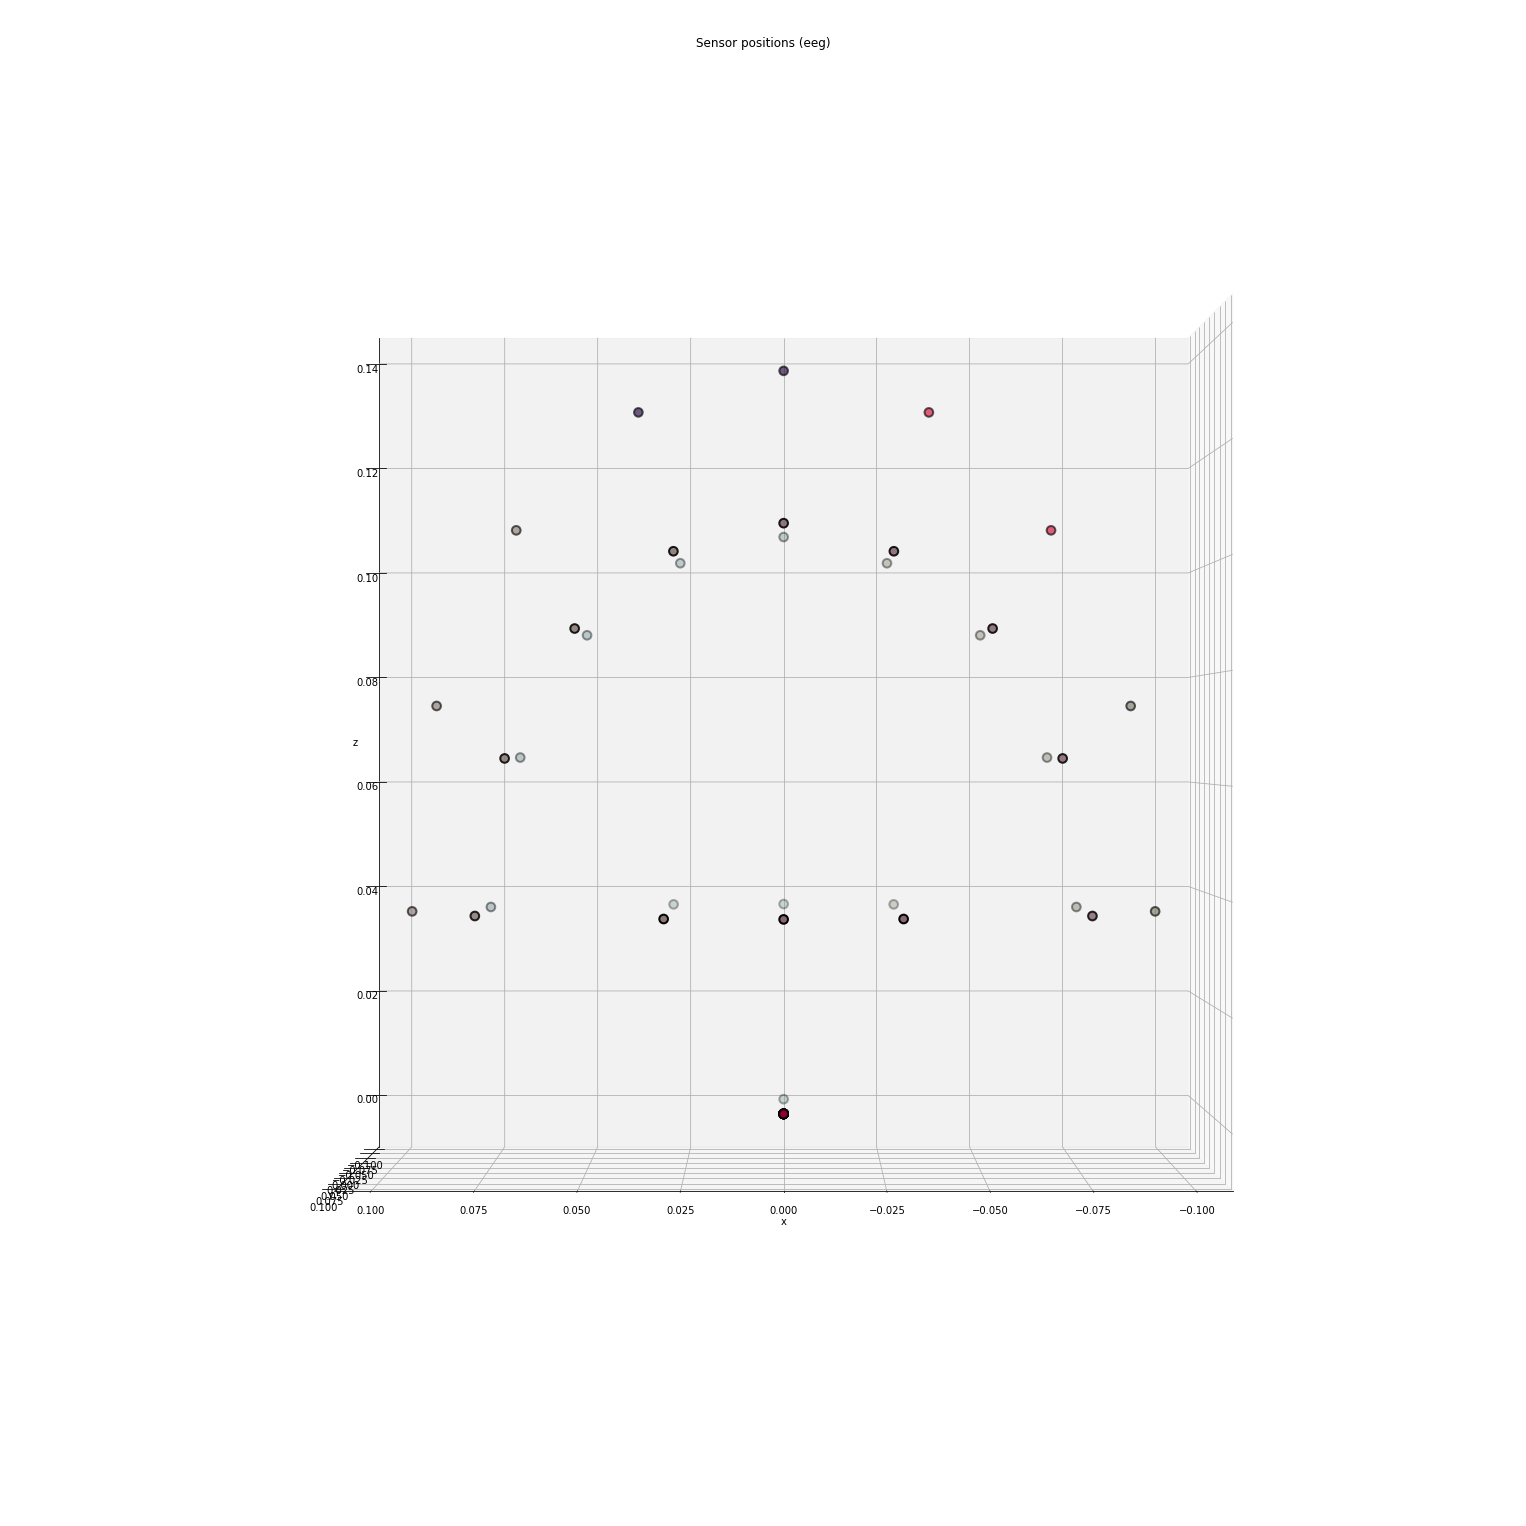

In [44]:
eeg.plot_sensors(kind='3d', ch_type='eeg', ch_groups='position')
plt.show()

In [70]:
picks = mne.pick_channels(
    eeg.info["ch_names"], [],
    exclude="Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, Cp5, Cp3, Cp1, Cpz, Cp2, Cp4, Cp6, Af7, Af3, Afz, Af4, Af8, Ft7, Ft8, Tp7, Tp8, Po7, Po3, Poz, Po4, Po8".split(", ")
)

In [71]:
epochs = mne.Epochs(
    eeg, 
    events, 
    event_id={
        "none": 1,
        "left": 2,
        "right": 3
    },
    picks=picks,
    tmin=tmin,
    tmax=tmax
)

30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [85]:
def plot_evoked_topo(event):
    evoked = epochs[event].average()
    times = np.linspace(0, 2, 20)
    evoked.plot_topomap(times, ch_type='eeg', time_unit='s')

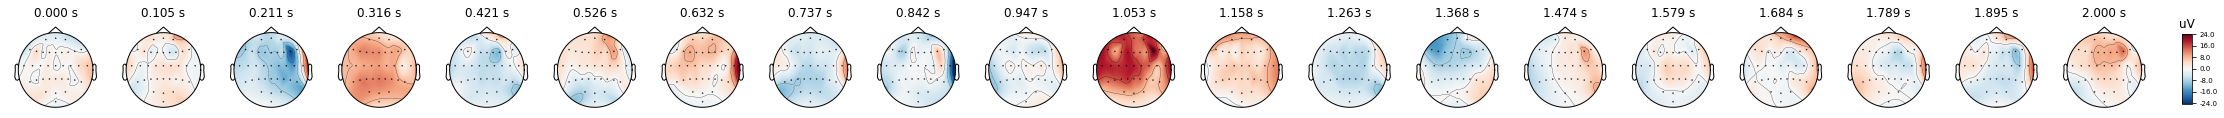

In [86]:
plot_evoked_topo("left")

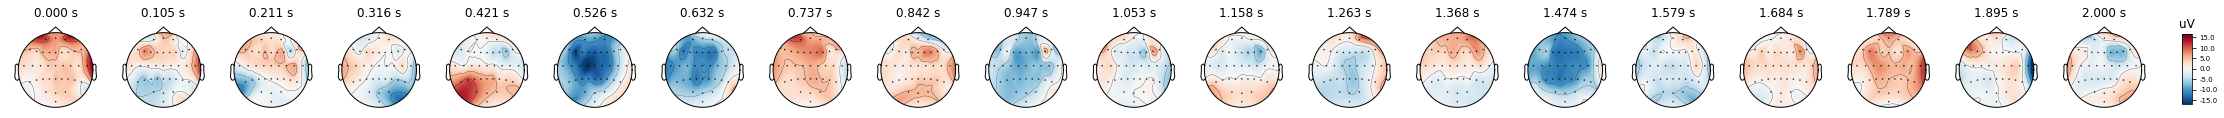

In [87]:
plot_evoked_topo("right")